### Attention of Softmax

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from model import generate_synthetic_data
text_length = 20
batch_size = 100
vocab_size = 10000
data,labels,Pos,Neg,Neu = generate_synthetic_data(datasize=50000,vocab_size=vocab_size,polarity_size=1000)
print(len(data),len(labels))

50000 50000


In [3]:
from model import MyDataSet
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

batch = Variable(torch.LongTensor(X_train))
labels = Variable(torch.LongTensor(y_train))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [4]:
from model import SelfAttnClassifier

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 200, 100, 1, scale=5.0,score_function='additive',activation='SoftMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [5]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [04:53<00:00,  2.93s/it]


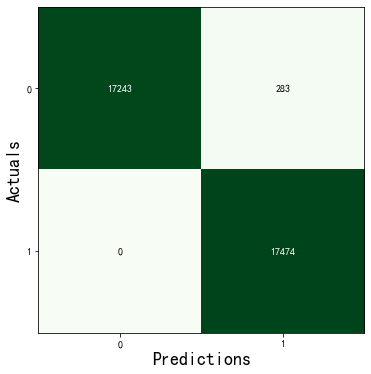

accuracy:99.191%


In [6]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/SoftmaxTrainAcc.png')

### test accuracy

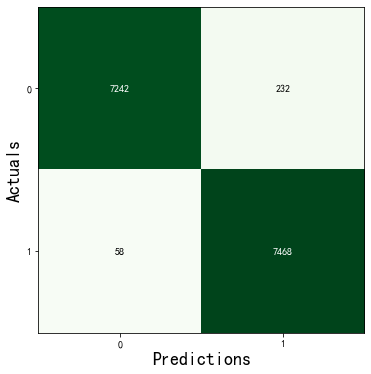

accuracy:98.067%


In [7]:
test_batch = Variable(torch.LongTensor(X_test))
test_labels = Variable(torch.LongTensor(y_test))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture3.png')

### Save Model

In [8]:
## 保存
torch.save(model.state_dict(), 'model/SoftmaxParameter.pkl')
torch.save(model, 'model/SoftmaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Visualization

In [9]:
from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu)

Pos Mean: 5.685701633214951 Pos Std: 6.657248631499191
Neg Mean: 4.178857054173946 Neg Std: 6.856036154178953
Neu Mean: -5.537995680973451 Neu Std: 3.5047636172955823


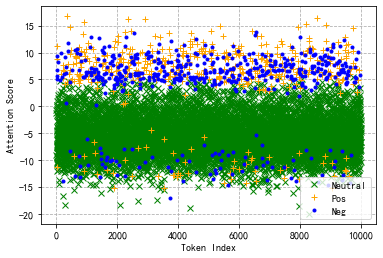

In [10]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture1.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.48567140863492514 Pos Std: 0.28610648781851294
Neg Mean: 0.47781821682099146 Neg Std: 0.29126882813611304
Neu Mean: 0.002799148816455245 Neu Std: 0.01144578411899759


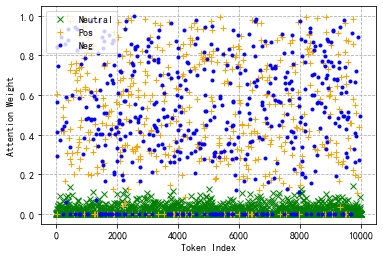

In [11]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture2.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1--Feature Importance

3000it [00:05, 567.92it/s]


Both label
	p-value < 0.05: 2998  ratio: 0.9993333333333333
	p-value < 0.01: 2979  ratio: 0.993
	Both-Mean: 0.8400458187645687 Std: 0.08284690607782737

Pos
	p-value < 0.05: 1536  ratio: 0.9993493819128172
	p-value < 0.01: 1527  ratio: 0.9934938191281718
	Pos-Mean: 0.8399421875023696 Std: 0.08138229572450413

Neg
	p-value < 0.05: 1462  ratio: 0.9993164730006835
	p-value < 0.01: 1452  ratio: 0.9924812030075187
	Neg-Mean: 0.8401546917994286 Std: 0.08435807511968572


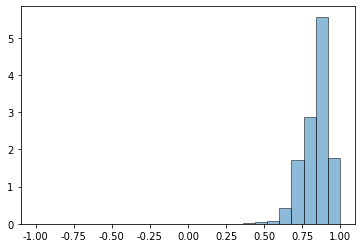

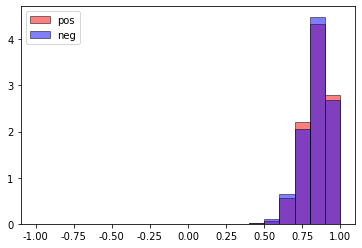

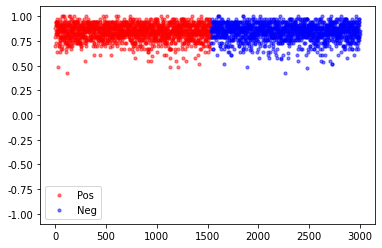

In [12]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'Softmax')

### Exp2--Feature Erasure

3000it [00:17, 175.72it/s]


Both label
	p-value < 0.05: 1036  ratio: 0.3453333333333333
	p-value < 0.01: 118  ratio: 0.03933333333333333
	total num: 3000  mean: 0.052568029034441244  std: 0.43901907008414826
Pos
	p-value < 0.05: 374  ratio: 0.24333116460637605
	p-value < 0.01: 2  ratio: 0.0013012361743656475
	total num: 1537  mean: 0.44604800522724664  std: 0.06698027411697377
Neg
	p-value < 0.05: 662  ratio: 0.4524948735475051
	p-value < 0.01: 116  ratio: 0.07928913192071087
	total num: 1463  mean: -0.3608145570273099  std: 0.23867999728013908


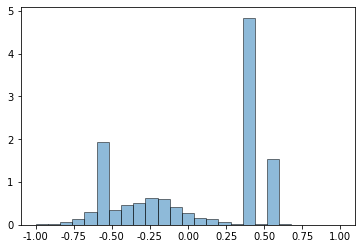

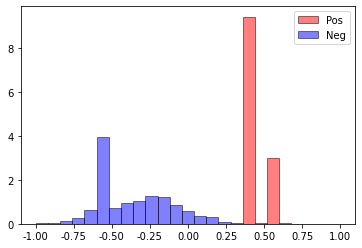

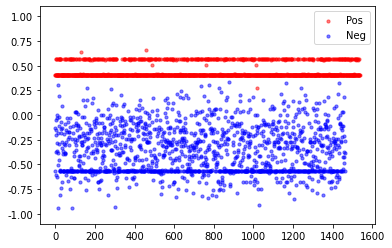

In [13]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'Softmax')

### Exp3--Feature Erasure ABS

3000it [00:18, 165.17it/s]


Both label
	p-value < 0.05: 1791  ratio: 0.597
	p-value < 0.01: 912  ratio: 0.304
	total num: 3000  mean: 0.5860697920197365  std: 0.19370125664004068
Pos
	p-value < 0.05: 375  ratio: 0.24398178269355889
	p-value < 0.01: 3  ratio: 0.001951854261548471
	total num: 1537  mean: 0.4463111932021835  std: 0.06708141863094576
Neg
	p-value < 0.05: 1416  ratio: 0.9678742310321258
	p-value < 0.01: 909  ratio: 0.621326042378674
	total num: 1463  mean: 0.7328975202374941  std: 0.17358518166531858


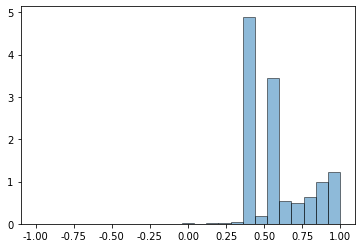

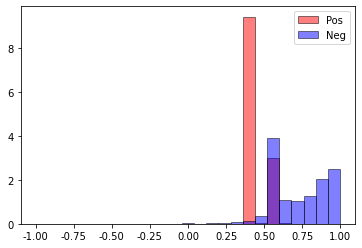

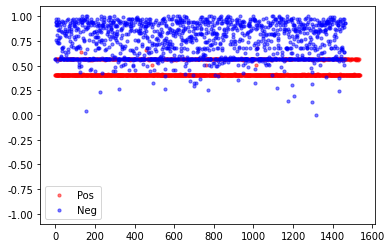

In [14]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'Softmax')

### Exp4--Attention Permutation

3000it [01:44, 28.72it/s]


Both label
	total num: 3000  mean: 0.3668312  std: 0.1574398
Pos
	total num: 1537  mean: 0.32982498  std: 0.14625326
Neg
	total num: 1463  mean: 0.40570933  std: 0.1593931


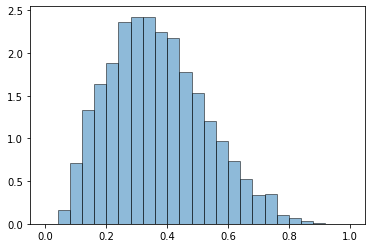

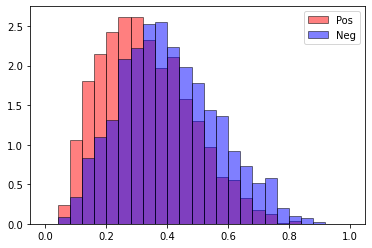

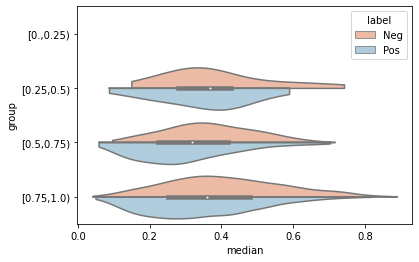

                  median                                                    \
                   count      mean       std       min       25%       50%   
label group                                                                  
Neg   [0.25,0.5)    17.0  0.385472  0.154622  0.148841  0.299876  0.364667   
      [0.5,0.75)   209.0  0.366808  0.124441  0.095316  0.280898  0.363040   
      [0.75,1.0)  1237.0  0.412560  0.163854  0.040577  0.291903  0.399421   
Pos   [0.25,0.5)    18.0  0.353064  0.131160  0.086406  0.256816  0.377147   
      [0.5,0.75)   230.0  0.292779  0.134408  0.057342  0.193962  0.274731   
      [0.75,1.0)  1289.0  0.336111  0.147628  0.048995  0.220039  0.321229   

                                      
                       75%       max  
label group                           
Neg   [0.25,0.5)  0.412544  0.741954  
      [0.5,0.75)  0.457282  0.715657  
      [0.75,1.0)  0.525785  0.889437  
Pos   [0.25,0.5)  0.431287  0.588734  
      [0.5,0.75)  0.3731

In [15]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'Softmax')

### Exp5--Attention Randomization

3000it [01:28, 33.80it/s]


Both label
	total num: 3000  mean: 1.525951e-05  std: 0.00067617156
Pos
	total num: 1537  mean: 1.0073262e-06  std: 1.1810109e-05
Neg
	total num: 1463  mean: 3.0232579e-05  std: 0.0009679659


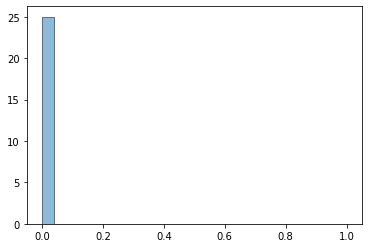

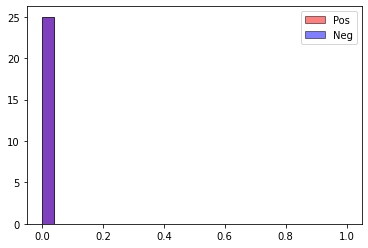

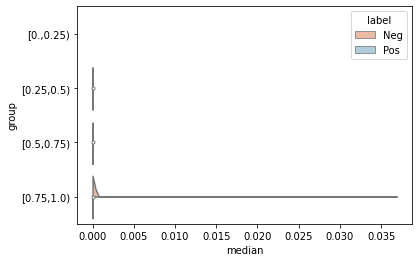

                  median                                            \
                   count          mean           std           min   
label group                                                          
Neg   [0.25,0.5)    17.0  2.927667e-06  8.651070e-06  1.947470e-10   
      [0.5,0.75)   209.0  2.674002e-06  1.502971e-05  1.715462e-11   
      [0.75,1.0)  1237.0  3.526405e-05  1.053012e-03  1.137477e-11   
Pos   [0.25,0.5)    18.0  2.450413e-07  7.765816e-07  0.000000e+00   
      [0.5,0.75)   230.0  5.374784e-07  3.154463e-06  0.000000e+00   
      [0.75,1.0)  1289.0  1.101807e-06  1.283002e-05  0.000000e+00   

                                                                      
                           25%           50%           75%       max  
label group                                                           
Neg   [0.25,0.5)  1.264042e-09  1.742615e-08  1.927788e-07  0.000035  
      [0.5,0.75)  1.637480e-09  2.134262e-08  1.796597e-07  0.000148  
      [0.75,1.

In [16]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'Softmax')